In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz


transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))
                               ])
training_dataset = datasets.MNIST(root='./', train=True, download=True, transform = transform)
val_dataset = datasets.MNIST(root='./', train=False, download=True, transform = transform)
training_dataset

'wget' is not recognized as an internal or external command,
operable program or batch file.
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [4]:
def img_convert(tensor):
    im = tensor.cpu().clone().detach().numpy() # right now the image is of form (1,28,28), need it to be (28,28,1)
    im = im.transpose(1,2,0) # now we get (28,28,1)
    #denormalization
    im = im * np.array((0.5,)) + np.array((0.5,))
    im = im.clip(0,1) #to ensure the range is indeed between 0 and 1
    
    return im

In [5]:
training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size = 100, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size = 100, shuffle=False) #no training in this dataset, so no need to shuffle

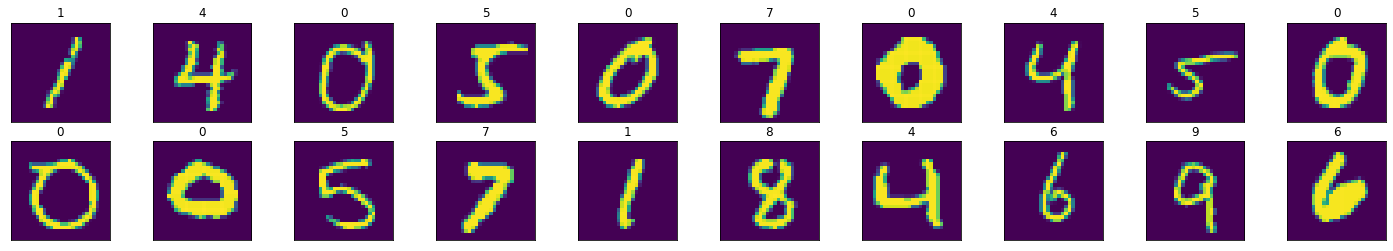

In [6]:
im_iter = iter(training_loader)
imgs, labels = im_iter.next()
fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2,10, i+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(img_convert(imgs[i])))
    ax.set_title(labels[i].item())

In [7]:
class LeNetModel (nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,20,5,1)
        self.conv2 = nn.Conv2d(20,50,5,1)
        self.full_conn1 = nn.Linear(50*4*4, 500) #28x28 -> 5x5kernel -> 24x24 -> pooling -> 12x12 -> 5x5kernel -> 8x8 -> pooling -> 4x4
        self.dropout1 = nn.Dropout(0.5)
        self.full_conn2 = nn.Linear(500, 10)
        
        #no need to do padding as the image edges are not that important to do convolution on
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2,2) # cut image size by half
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2,2)
        x = x.view(-1, 4*4*50) # must be flattent to go to fully connected layer
        x = F.relu(self.full_conn1(x))
        x = self.dropout1(x)
        x = self.full_conn2(x)
        return x

In [8]:
model = LeNetModel().to(device)
model

LeNetModel(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (full_conn1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (full_conn2): Linear(in_features=500, out_features=10, bias=True)
)

In [9]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) #smaller learning rate will make the plot of loss function more smooth, as it will avoid overshooting

In [10]:
epochs = 10
losses = []
accuracies = []

val_losses = []
val_accuracies = []

In [11]:
for i in range(epochs):
    print("epoch: ", i+1)
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    val_epoch_loss = 0.0
    val_epoch_acc = 0.0
    
    for images, labels in training_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model.forward(images)
        loss = loss_func(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, max_idx = torch.max(outputs, 1) # 1 here indicates dim = 1, which is calculating max in horizontal direction, dim = 0 is vertical, dim = 2 is in depth direction.
        epoch_loss += loss.item()
        epoch_acc += torch.sum(max_idx == labels.data).item() # since batch size is 100, no need to divide by size then multiply by 100 to get % accuracy.

    
    tot_loss = epoch_loss/len(training_loader)
    tot_acc = epoch_acc/len(training_loader)
    losses.append(tot_loss)
    accuracies.append(tot_acc)
    print("training loss: {:.4f}, accuracy: {:.4f}".format(tot_loss, tot_acc))
    
    #validation phase
    
    with torch.no_grad(): #to save memory, set all grad flags to False
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            val_outputs = model.forward(val_images)
            val_loss = loss_func(val_outputs, val_labels)

            _, max_idx = torch.max(val_outputs, 1)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += torch.sum(max_idx == val_labels.data).item()
     
    val_tot_loss = val_epoch_loss/len(val_loader)
    val_tot_acc = val_epoch_acc/len(val_loader)
    val_losses.append(val_tot_loss)
    val_accuracies.append(val_tot_acc)
    print("val loss: {:.4f}, val accuracy: {:.4f}".format(val_tot_loss, val_tot_acc))

epoch:  1
training loss: 0.5771, accuracy: 84.4600
val loss: 0.1881, val accuracy: 94.6600
epoch:  2
training loss: 0.1542, accuracy: 95.4567
val loss: 0.1089, val accuracy: 96.7500
epoch:  3
training loss: 0.1028, accuracy: 96.9167
val loss: 0.0760, val accuracy: 97.8300
epoch:  4
training loss: 0.0800, accuracy: 97.6317
val loss: 0.0635, val accuracy: 97.8900
epoch:  5
training loss: 0.0658, accuracy: 98.0150
val loss: 0.0575, val accuracy: 98.1800
epoch:  6
training loss: 0.0559, accuracy: 98.3233
val loss: 0.0482, val accuracy: 98.4900
epoch:  7
training loss: 0.0502, accuracy: 98.4933
val loss: 0.0444, val accuracy: 98.5600
epoch:  8
training loss: 0.0442, accuracy: 98.6317
val loss: 0.0409, val accuracy: 98.7000
epoch:  9
training loss: 0.0401, accuracy: 98.8067
val loss: 0.0357, val accuracy: 98.8100
epoch:  10
training loss: 0.0369, accuracy: 98.9133
val loss: 0.0358, val accuracy: 98.8000


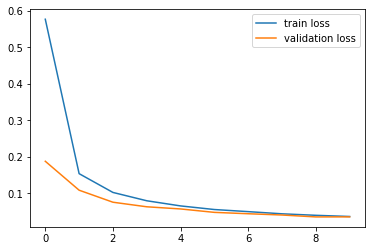

In [12]:
plt.plot(losses, label = 'train loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()

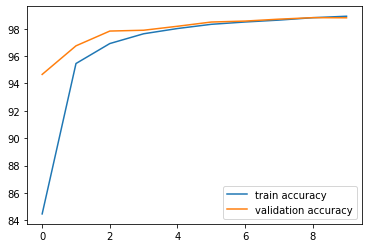

In [13]:
plt.plot(accuracies, label = 'train accuracy')
plt.plot(val_accuracies, label = 'validation accuracy')
plt.legend()

<Response [200]>


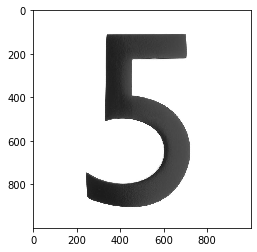

In [14]:
import requests
import PIL
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream=True)
print(response)
img = Image.open(response.raw)
plt.imshow(img)


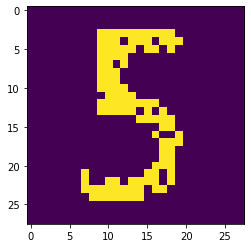

In [15]:
#need to transform image to 28 by 28

import PIL.ImageOps

img = PIL.ImageOps.invert(img) #invert the color, black -> white and vice versa
img = img.convert('1') # change to black and white
img = transform(img)
plt.imshow(np.squeeze(img_convert(img))) #now is is like the images we trained

In [16]:
img = img.to(device)
img = img.unsqueeze(0)
outputs = model.forward(img)
_, max_idx = torch.max(outputs, 1)
print(max_idx.item())

5


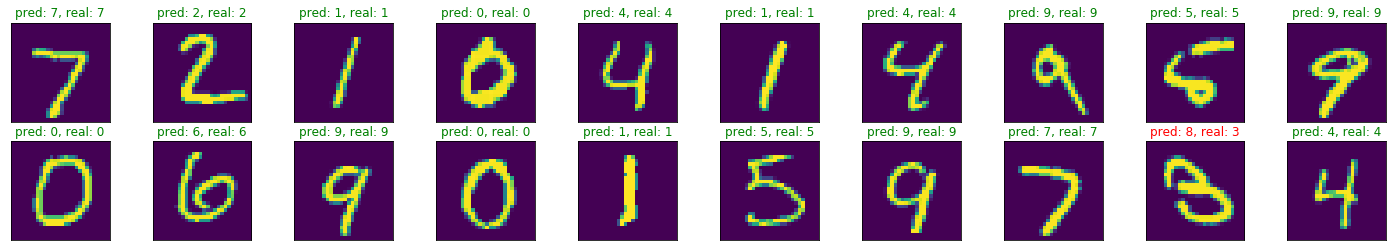

In [17]:
im_iter = iter(val_loader)
images, labels = im_iter.next() # just take one batch and visualize some of these images
images = images.to(device)
labels = labels.to(device)

outputs = model.forward(images)
_, max_idx = torch.max(outputs, 1)


fig = plt.figure(figsize=(25,4))

for i in range(20):
    ax = fig.add_subplot(2,10, i+1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(img_convert(images[i])))
    ax.set_title("pred: {}, real: {}".format(str(max_idx[i].item()), str(labels[i].item())), color = ("green" if max_idx[i] == labels[i] else "red"))